# Neural Networks and Deep Learning Assignment

## Importing Libraries
Pytorch libraries are used to implement the neural network with implementation in place to use an NVIDIA GPUs available on Google Colab. Functionality is also in place to make use of Microsofts direct_ml library to fully utilize non NVIDIA GPUs

In [1]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install torch-directml
import torch_directml
dml = torch_directml.device()

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f'Currently using {device}')

## Loading the Datasets
The following code downloads the images from the in built CIFAR 10 dataset and applies transformation to normalize the images and to convert them into tensors for use by PyTorch

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

cifar_dataset_train = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
cifar_dataset_test = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## Creating the training dataset
The Data itself needs to be made iterable in order to utilize the mini batch methodology

In [3]:
from torch.utils.data import DataLoader
batch_size = 100

train_iter = DataLoader(cifar_dataset_train,batch_size,shuffle=True,num_workers=2)

In [4]:
X,y = next(iter(train_iter))

## Creating the test dataset
The Data itself needs to be made iterable in order to utilize the mini batch methodology

In [5]:
test_iter = DataLoader(cifar_dataset_test,batch_size,shuffle=False,num_workers=2)

In [6]:
X_test,y_test = next(iter(test_iter))

## Analysing the CIFAR-10 data
Below shows the dataset in more granular detail. We can see that the images are in a 32x32 image with 3 channels

In [7]:
print(f'The dimensions of each input image is {X.size()} The number of input channels is {X.size()[1]}')

The dimensions of each input image is torch.Size([100, 3, 32, 32]) The number of input channels is 3


In [8]:
print(f'The output labels are as follows {y}')

The output labels are as follows tensor([5, 9, 3, 9, 8, 6, 7, 8, 5, 0, 6, 2, 8, 5, 2, 3, 8, 5, 4, 9, 1, 2, 3, 8,
        3, 7, 8, 0, 4, 2, 5, 5, 4, 6, 4, 6, 3, 3, 6, 1, 9, 1, 5, 2, 6, 8, 8, 1,
        6, 7, 6, 4, 3, 2, 5, 7, 6, 2, 5, 1, 5, 7, 3, 2, 4, 0, 4, 4, 5, 2, 6, 4,
        2, 6, 0, 9, 0, 9, 3, 3, 7, 1, 2, 5, 3, 7, 5, 3, 6, 1, 5, 2, 4, 9, 7, 6,
        9, 2, 7, 1])


In [9]:
print(f'The number of classes is {len(np.unique(y.numpy()))}')

The number of classes is 10


## Example image

## CNN Architecture
Discussed in Detail in the Report

In [10]:
class Block(torch.nn.Module): ## Create Block Class (k=2, i.e two convolutions and two values of the linear layer)
    def __init__(self,input_channels,output_channels,strides,features,out_features,use_1x1conv=False):
        super(Block,self).__init__()
        self.output_channels = output_channels

        # Design of the first convolution element
        self.b1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_channels,out_channels=output_channels,kernel_size=3,stride=strides,padding=1),
            torch.nn.BatchNorm2d(output_channels),
            torch.nn.ReLU(),
        )

        # Design the second convolution element
        self.b2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=input_channels,out_channels=output_channels,kernel_size=5,stride=strides,padding=2),
            torch.nn.BatchNorm2d(output_channels),
            torch.nn.ReLU(),
        )

        # Design the Linear element as specified in the assignment dossier
        self.linear = torch.nn.Sequential(
            torch.nn.AdaptiveAvgPool2d((8,8)),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=features,out_features=out_features),
            torch.nn.ReLU(),
            torch.nn.Dropout(0)
        )

        # Design Element for skip connection
        if use_1x1conv:
            self.conv = torch.nn.Conv2d(input_channels,output_channels,kernel_size=1,stride=strides)

        else:
            self.conv = None

    def forward(self,x):

        b1 = self.b1(x) # implement the first block element
        b2 = self.b2(x) # implement the second block element

        linear = self.linear(x) # implement the linear element

        # Multiply each block by the requisite element in the form a1xConv1(x)
        o1 = (linear[:,0].view(100,-1) * b1.view(100,-1))
        o2 = (linear[:,1].view(100,-1) * b2.view(100,-1))

        # Add the above tensors
        out = (o1+o2).view(100,self.output_channels,x.size(2),-1)

        if self.conv:
            x = self.conv(x)

        # Implement the skip connection
        out = torch.nn.functional.relu(x + out)

        return out

In [11]:
class CNN(torch.nn.Module): # Create the CNN composed of two blocks and a classifier element
    def __init__(self,num_classes):
        super(CNN,self).__init__()

        # Create the Stem element to process the initial input images
        self.stem = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3,out_channels=3,kernel_size=1,stride=1,padding=0),
            torch.nn.BatchNorm2d(3),
            torch.nn.ReLU(),
        )

        # Implement the two Blocks
        self.block1 = Block(input_channels=3,output_channels=64,features=192,out_features=2,strides=1,use_1x1conv=True)
        self.block2 = Block(input_channels=64,output_channels=128,features=4096,out_features=2,strides=1,use_1x1conv=True)

        # Implement the last element which average pools the output of the final block then creates a linear layer
        self.last = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d((12,12)),
                                        torch.nn.Flatten(),
                                        torch.nn.Linear(in_features=18432,out_features=500),
                                        torch.nn.ReLU(),
                                        torch.nn.Dropout(0)
                                        )

        # Implement the last linear layer and applying softmax
        self.linear = torch.nn.Sequential(
            torch.nn.Linear(in_features=500,out_features=num_classes),
            torch.nn.ReLU(),
            torch.nn.Dropout(0),
            torch.nn.Softmax(dim=1)
        )

    def forward(self,x):

        output = self.stem(x)

        output = self.block1(output)
        output = self.block2(output)

        output = self.last(output)

        output = self.linear(output)

        return output

In [12]:
model = CNN(num_classes=10).to(dml)
print(model)

CNN(
  (stem): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (block1): Block(
    (b1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (b2): Sequential(
      (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (linear): Sequential(
      (0): AdaptiveAvgPool2d(output_size=(8, 8))
      (1): Flatten(start_dim=1, end_dim=-1)
      (2): Linear(in_features=192, out_features=2, bias=True)
      (3): ReLU()
      (4): Dropout(p=0, inplace=False)
    )
    (conv): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
  )
  (block2): Block(
    (b1): Sequential(
      (0): Co

## Create Loss and Optimization

In [13]:
loss = torch.nn.CrossEntropyLoss()

# Create the optimizer term
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,weight_decay=0.005,momentum=0.5)

## Calculate Loss, and Validation Accuracy

In [18]:
def train_test_model(model,train_iter,test_iter,epochs,optimizer,loss):
    for epoch in range(epochs): # Initialize the epochs

        l_score = []
        train_score = []
        test_score = []

        for i,(X,y) in enumerate(train_iter):

            X = X.to(dml)
            y = y.to(dml)

            optimizer.zero_grad()

            #model.train()
            y_hat = model(X)
            l = loss(y_hat,y)

            l.backward()
            optimizer.step()

        l_score.append(l.item())
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {l.item():.4f}')

        with torch.no_grad():
            correct = 0
            total = 0
            for data in test_iter:
                X_test,y_test = data
                X_test = X_test.to(dml)
                y_test = y_test.to(dml)

                y_hat = model(X_test)

                _, predicted = torch.max(y_hat.data,1)
                total += y_test.size(0)
                correct += (predicted == y_test).sum().item()

            test_score.append(100 * correct // total)
            print(f'Accuracy of the network on the test images is : {100 * correct // total} percent')

            for data in train_iter:
                X,y = data
                X = X.to(dml)
                y = y.to(dml)

                y_hat = model(X)

                _, predicted = torch.max(y_hat.data,1)
                total += y.size(0)
                correct += (predicted == y).sum().item()

            train_score.append(100 * correct // total)
            print(f'Accuracy of the network on the train images is : {100 * correct // total} percent')

        return l_score,train_score,test_score

In [19]:
epochs = 1
l,tr,te = train_test_model(model,train_iter,test_iter,epochs,optimizer,loss)

Epoch [1/1], Loss: 2.0908
Accuracy of the network on the test images is : 40 percent
Accuracy of the network on the train images is : 40 percent


Text(0, 0.5, 'loss')

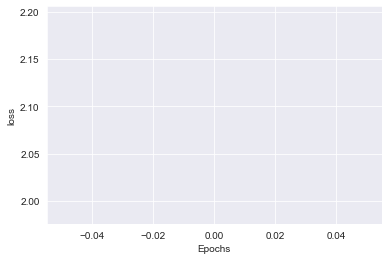

In [25]:
sns.lineplot(x=range(epochs),y=l)
plt.xlabel('Epochs')
plt.ylabel('loss')

<AxesSubplot:>

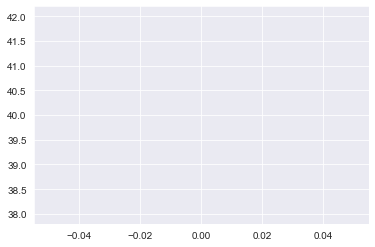

In [23]:
sns.lineplot(x=range(epochs),y=tr)
plt.xlabel('Epochs')
plt.ylabel('accuracy')

In [ ]:
sns.lineplot(x=range(epochs),y=te)
plt.xlabel('Epochs')
plt.ylabel('accuracy')